### Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. - Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

#### Инструкция по выполнению проекта
- Загрузите данные и выполните их ресемплирование по одному часу.
- Проанализируйте данные.
- Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
- Проверьте данные на тестовой выборке и сделайте выводы.

In [138]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
import copy

### Загрузите данные и выполните их ресемплирование по одному часу.

In [79]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

### Проанализируйте данные.

In [4]:
#напишем функцию для обзора данных
def data_info(dataset):
    cols = dataset.columns
    colours = ['#000099', '#ffff00'] 
    sns.heatmap(dataset[cols].isnull(), cmap=sns.color_palette(colours))
    print('')
    print('Shape:')
    display(dataset.shape)
    print('')
    print('Head:')
    display(dataset.head())
    print('')
    print('Corr:')
    display(dataset.corr())
    df_plot = sns.heatmap(dataset.corr(), cmap="YlGnBu", annot=True)      
    plt.show()
    print('')
    print('Describe:')
    print('')
    display(dataset.describe())  
    print('Info:')
    print('')
    display(dataset.info())   
    print('Duplicated:')
    #print('')
    display(dataset[dataset.duplicated ()])
    #Процентный список пропущенных данных
    print('isna:')
    print('')
    for col in data.columns:
        pct_missing = np.mean(data[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))


Shape:


(4416, 1)


Head:


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



Corr:


,num_orders
num_orders,1.0


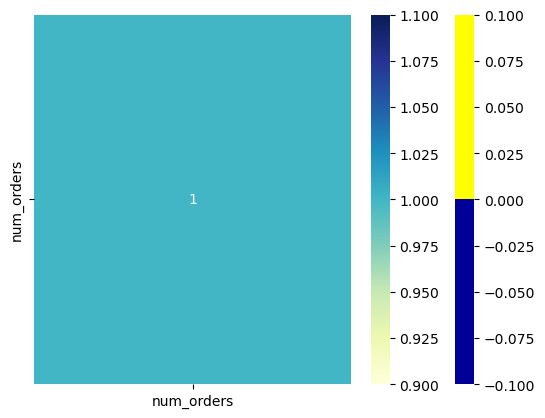


Describe:



,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

Duplicated:


,num_orders
datetime,
2018-03-01 15:00:00,66
2018-03-01 16:00:00,43
2018-03-01 21:00:00,66
2018-03-02 03:00:00,64
2018-03-02 06:00:00,11
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


isna:

num_orders - 0%


In [5]:
data_info(data)

In [6]:
data[data.index.min():data.index.max()]

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<AxesSubplot:xlabel='datetime'>

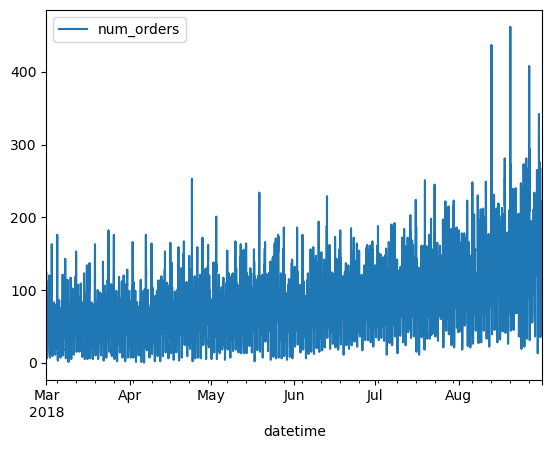

In [7]:
data.plot()

In [31]:
def show_graph(dataset, windowsize):
    # зададим размер графика
    plt.figure(figsize = (15,8))

    # поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
    plt.plot(dataset, label = 'Количество заказов по часам', color = 'steelblue')
    plt.plot(dataset.rolling(window = windowsize).mean(), label = 'Скользящее среднее за {windowsize} ч.'.format(windowsize= windowsize), color = 'orange')

    # добавим легенду, ее положение на графике и размер шрифта
    plt.legend(title = '', loc = 'upper left', fontsize = 14)

    # добавим подписи к осям и заголовки
   # plt.xlabel('', fontsize = 14)
    plt.ylabel('Количество заказов', fontsize = 14)
    plt.title('Количество заказов за все время', fontsize = 16)

    # выведем обе кривые на одном графике
    plt.show()

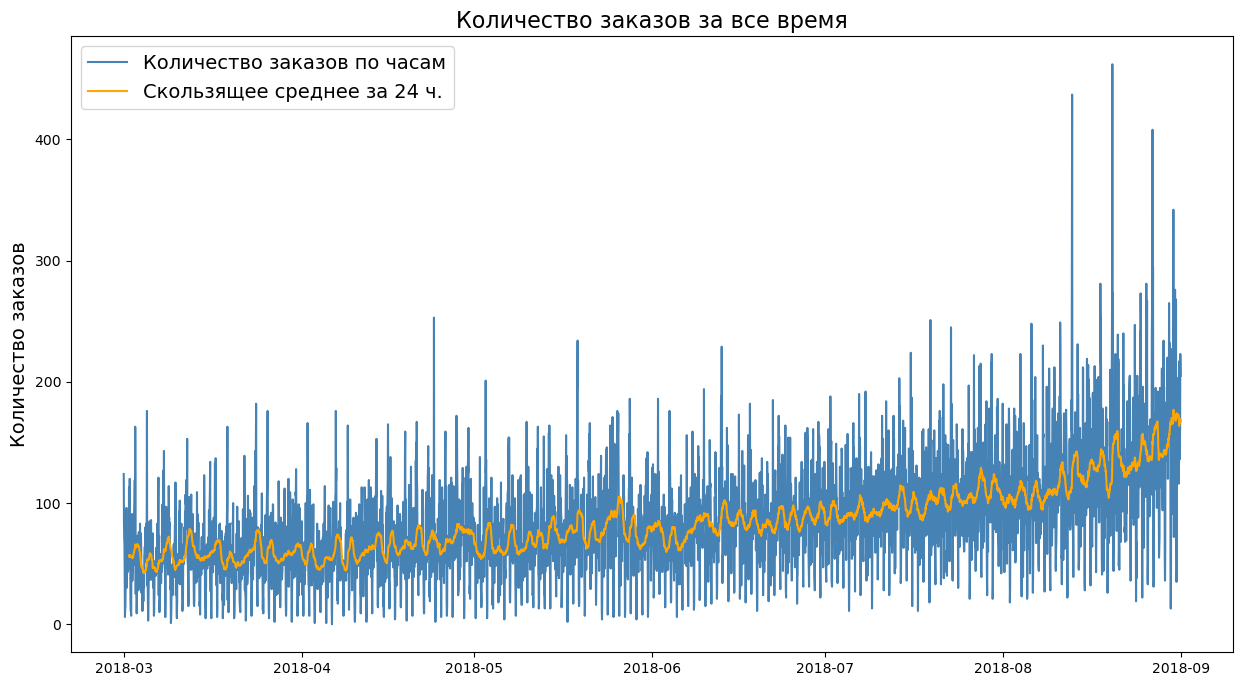

In [42]:
show_graph(data, 24)

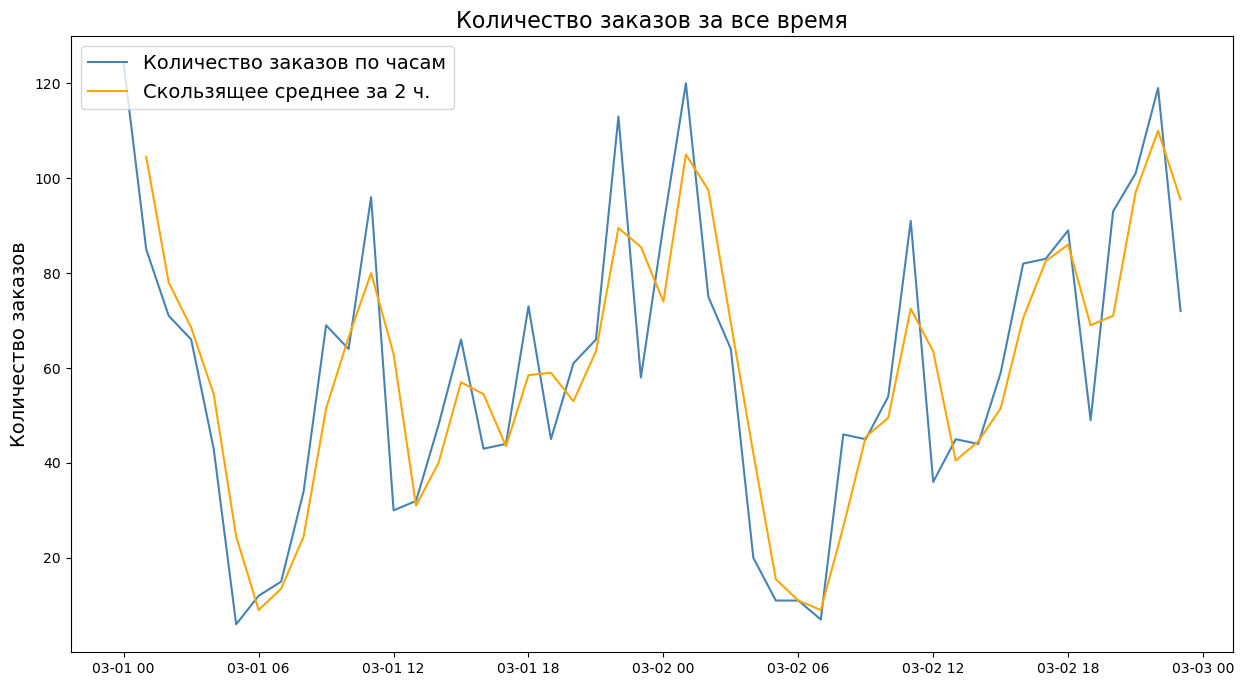

In [41]:
show_graph(data['2018-03-01':'2018-03-02'], 2)

#### Разложение временного ряда на компоненты

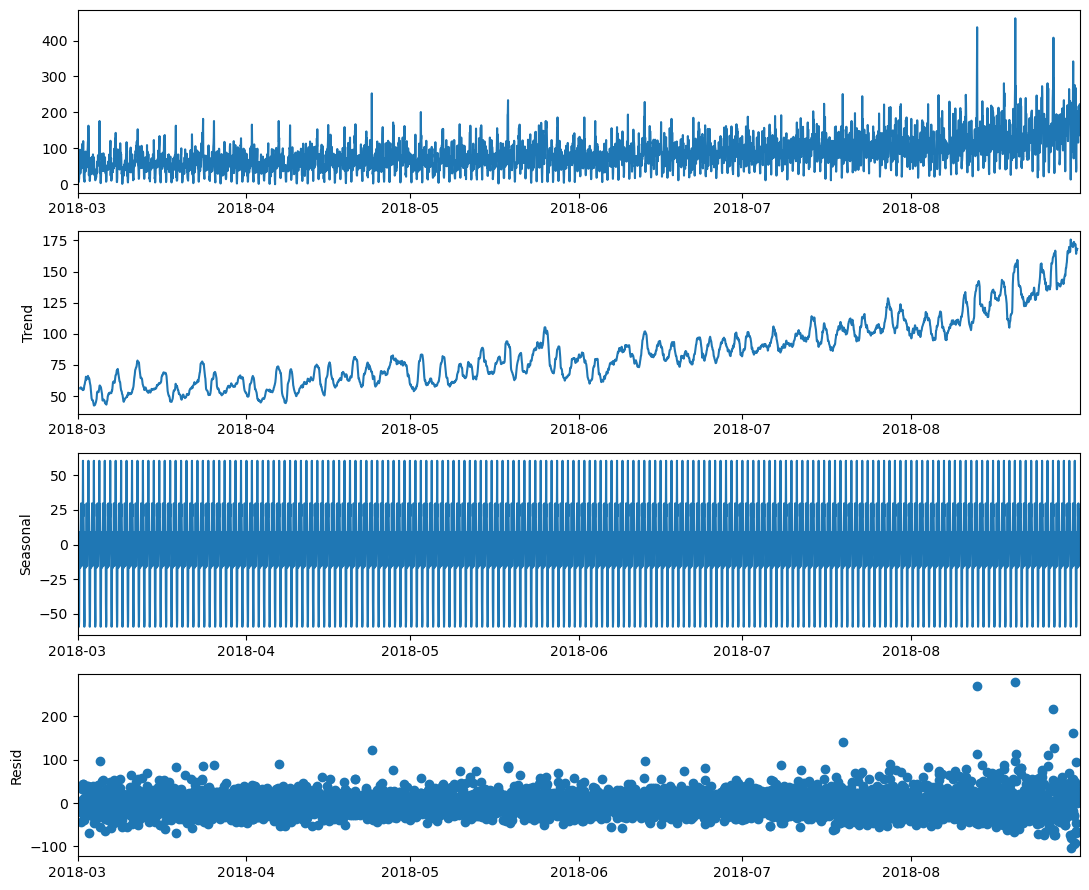

In [45]:
rcParams['figure.figsize'] = 11, 9
 
# применяем функцию к данным о перевозках
decompose = seasonal_decompose(data)
decompose.plot()
 
plt.show()

#### Результат анализа

- Один столбец и даты  в индексе
- 4416 строк
- Данные монолитны, пропусков нет
- Минимальное значение 0, максимальное 462
- Коррелировать не с чем
- С датасетом можно работать
- Промежуток дат с 2018-03-01 00:00:00 по 2018-08-31 23:00:00
- Сезонность определить не получится ввиду того что срез небольшой
- По графикам видно что спрос на такси растет  ночью и падает к утру
- С 2017 года наблюдаем положительную динамику количества заказов

### Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

In [109]:
#Над данными мы еще немного поработаем добавив фич:
df = copy.copy(data) 
def make_features(dataset, max_lag, rolling_mean_size):
    dataset['year'] = dataset.index.year
    dataset['month'] = dataset.index.month
    dataset['day'] = dataset.index.day
    dataset['dayofweek'] = dataset.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        dataset['lag_{}'.format(lag)] = dataset['num_orders'].shift(lag)

    dataset['rolling_mean'] = dataset['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 9, 1)

train, test = train_test_split(df, test_size = 0.1, shuffle=False)
train = train.dropna()

train_x = train.drop(['num_orders'], axis = 1)
train_y = train['num_orders']

test_x = test.drop(['num_orders'], axis = 1)
test_y = test['num_orders']

#### LinearRegression

In [114]:
model = LinearRegression()


parametrs = { 'fit_intercept': [True, False],
              'n_jobs': [1, 50, 100],
              'positive': [True, False]}

#clf.get_params().keys()

grid = GridSearchCV(model, parametrs, cv=5)
grid.fit(train_x, train_y)
display(grid.best_params_)

{'fit_intercept': True, 'n_jobs': 1, 'positive': False}

In [145]:
model = LinearRegression(fit_intercept = True, n_jobs = 1, positive = False)
model.fit(train_x, train_y)

test_pred = model.predict(test_x)
linear = mean_squared_error(test_y, test_pred, squared= False)
display("RMSE тестовой выборки: ", linear)

'RMSE тестовой выборки: '

53.63125600056636

#### MLPRegressor

In [118]:

model = MLPRegressor()


parametrs = { 'hidden_layer_sizes': [1, 50, 100],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'max_iter': [1, 100, 200, 400]}

#clf.get_params().keys()

grid = GridSearchCV(model, parametrs, cv=5)
grid.fit(train_x, train_y)
display(grid.best_params_)

/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaco

/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/o

/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/ana

/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/o

/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fliutch/o

{'activation': 'relu', 'hidden_layer_sizes': 100, 'max_iter': 200}

In [140]:
model = MLPRegressor(activation = 'relu', hidden_layer_sizes = 100, max_iter =  200)
model.fit(train_x, train_y)

test_pred = model.predict(test_x)
mlpc =  mean_squared_error(test_y, test_pred, squared= False)
display("RMSE тестовой выборки: ", mlpc)

'RMSE тестовой выборки: '

55.59258402413955

#### Dummy

In [147]:
model = DummyRegressor()
model.fit(train_x, train_y)

test_pred = model.predict(test_x)
dummy =  mean_squared_error(test_y, test_pred, squared= False)
display("RMSE тестовой выборки: ", dummy)

'RMSE тестовой выборки: '

84.69882415876955

### Проверьте данные на тестовой выборке и сделайте выводы.

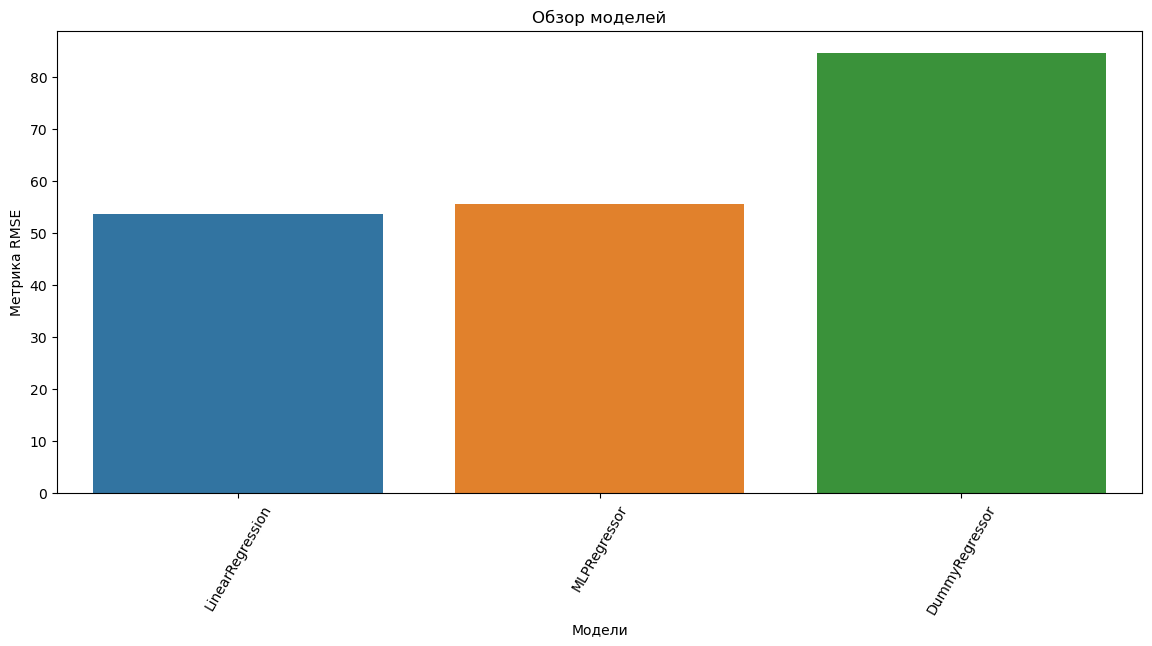

,model_name,rmse
0,LinearRegression,53.631256
1,MLPRegressor,55.592584
2,DummyRegressor,84.698824


In [169]:
modelnames = ['LinearRegression','MLPRegressor','DummyRegressor']
model_rmse = [linear, mlpc, dummy]
models_df = pd.DataFrame({'model_name':modelnames,'rmse':model_rmse})  

plt.figure(figsize=(14,6))
sns.barplot(x=models_df.model_name ,y=models_df.rmse)
plt.title("Обзор моделей")
plt.xlabel("Модели")
plt.ylabel("Метрика RMSE")
plt.xticks(rotation=60)
plt.show()
cols = ['model_name', 'rmse']
display(models_df[cols])
    

### Вывод

- В данные были добавлены значения временного сдвига размером от 1 до 9 и размер скользящего окна с вычслением среднего значения размером 1 
- Были обучены 3 модели и подобраны оптимальные параметры с помощью GridSearchCV
- Наименьшее значение rmse у линейной регрессии
- Наибольшее у DummyRegressor
- Регресионная модель многослойного перцептрона в даннос случае показала данные rmse чуть выше линейной регрессии. 